## Analyse et Prévision des Actions Automobiles : Étude de Volkswagen, BMW et Porsche



Ce projet vise à analyser les rendements, la volatilité, et les tendances des actions de trois grandes entreprises du secteur automobile : **Volkswagen**, **BMW**, et **Porsche**. À l’aide de modèles de séries temporelles tels qu’ARIMA, SARIMA, et Prophet, il explore les données historiques pour effectuer des prévisions sur les prix des actions et leur comportement futur. L’analyse principale se concentre sur Volkswagen, avec un code entièrement reproductible pour BMW et Porsche.


In [50]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import yfinance
import warnings

warnings.filterwarnings("ignore")
sns.set()

##  Data

In [51]:
raw_data = yfinance.download(
    tickers="VOW3.DE, PAH3.DE, BMW.DE", 
    interval="1d", 
    group_by='ticker',
    auto_adjust=True, 
    threads=True
)

[*********************100%***********************]  3 of 3 completed


In [52]:
df = raw_data.copy()

## Dates clés

In [53]:
df = df.loc['2014-01-01':'2024-12-31']


In [54]:
start_date = df.index.min().strftime('%Y-%m-%d')  
ann_1 = df.index[len(df) // 3].strftime('%Y-%m-%d')  
ann_2 = df.index[2 * len(df) // 3].strftime('%Y-%m-%d') 
end_date = df.index.max().strftime('%Y-%m-%d')  
d_gate = "2015-09-18"




In [56]:
print(f"{start_date}")
print(f"{ann_1}")
print(f"{ann_2}")
print(f"Dieselgate (d_gate): {d_gate}")
print(f"{end_date}")

2014-01-02
2017-08-31
2021-05-11
Dieselgate (d_gate): 2015-09-18
2024-12-30


## Preprocessing 

1. **`vol` (Volkswagen), `por` (Porsche), `bmw` (BMW)** :
    Ce sont les prix ajustés des actions pour Volkswagen, Porsche, et BMW respectivement.
2. **`q_vol`, `q_por`, `q_bmw`** :
    Les volumes échangés pour chaque action (quantité de transactions).
3. **`ret_vol`, `ret_por`, `ret_bmw`** :
    Les rendements journaliers en pourcentage pour chaque action, calculés comme la variation relative d'un jour à l'autre.



In [57]:
df['vol'] = df['VOW3.DE'].Close
df['por'] = df['PAH3.DE'].Close
df['bmw'] = df['BMW.DE'].Close
df['ret_vol'] = df['vol'].pct_change(1).mul(100)
df['ret_por'] = df['por'].pct_change(1).mul(100)
df['ret_bmw'] = df['bmw'].pct_change(1).mul(100)
df['sq_vol'] = df.ret_vol.pow(2)
df['sq_por'] = df.ret_por.pow(2)
df['sq_bmw'] = df.ret_bmw.pow(2)

df['q_vol'] = df['VOW3.DE'].Volume
df['q_por'] = df['PAH3.DE'].Volume
df['q_bmw'] = df['BMW.DE'].Volume


df = df.asfreq('b')
df = df.fillna(method='bfill')

# Supprime les colonnes inutiles
df.drop(columns=['VOW3.DE', 'PAH3.DE', 'BMW.DE'], inplace=True)

## Analyse 

In [58]:

print(df[['vol', 'por', 'bmw', 'q_vol', 'q_por', 'q_bmw', 'ret_vol', 'ret_por', 'ret_bmw']].describe())


Ticker          vol          por          bmw         q_vol         q_por  \
Price                                                                       
count   2868.000000  2868.000000  2868.000000  2.868000e+03  2.868000e+03   
mean      96.360103    49.078786    61.721305  1.225891e+06  5.906402e+05   
std       18.554483    11.965547    15.623749  7.451710e+05  4.032722e+05   
min       52.730488    24.677759    27.465967  0.000000e+00  0.000000e+00   
25%       84.359943    41.329496    50.686337  8.219210e+05  3.693465e+05   
50%       95.886711    46.925560    56.572382  1.061550e+06  5.029810e+05   
75%      106.809378    54.299945    68.981380  1.436483e+06  6.883760e+05   
max      156.763092    86.304756   108.059044  1.419737e+07  6.168811e+06   

Ticker         q_bmw      ret_vol      ret_por      ret_bmw  
Price                                                        
count   2.868000e+03  2868.000000  2868.000000  2868.000000  
mean    1.594243e+06     0.014708     0.013

Analyse générale des prix: 

Moyennes (mean) :Volkswagen a un prix moyen de 96.36 €, plus élevé que Porsche (49.08 €) et BMW (61.72 €).

Écart-types (std) :
Les prix de Volkswagen ont une volatilité plus élevée (18.55 €) que Porsche (11.97 €) et BMW (15.62 €)

Minimum et maximum :
 Volkswagen :
Minimum : 52.73 €, Maximum : 156.76 €.
Porsche :
Minimum : 24.68 €, Maximum : 86.30 €.
BMW :
Minimum : 27.46 €, Maximum : 108.05 €.

Quartiles (25%, 50%, 75%) :
Pour Volkswagen :
50 % des prix étaient inférieurs à 95.88 € (médiane).
25 % des prix étaient inférieurs à 84.36 € (1er quartile).
75 % des prix étaient inférieurs à 106.80 € (3ème quartile).
Cela montre une distribution relativement homogène autour de la médiane.

#### Visualisation  des prix

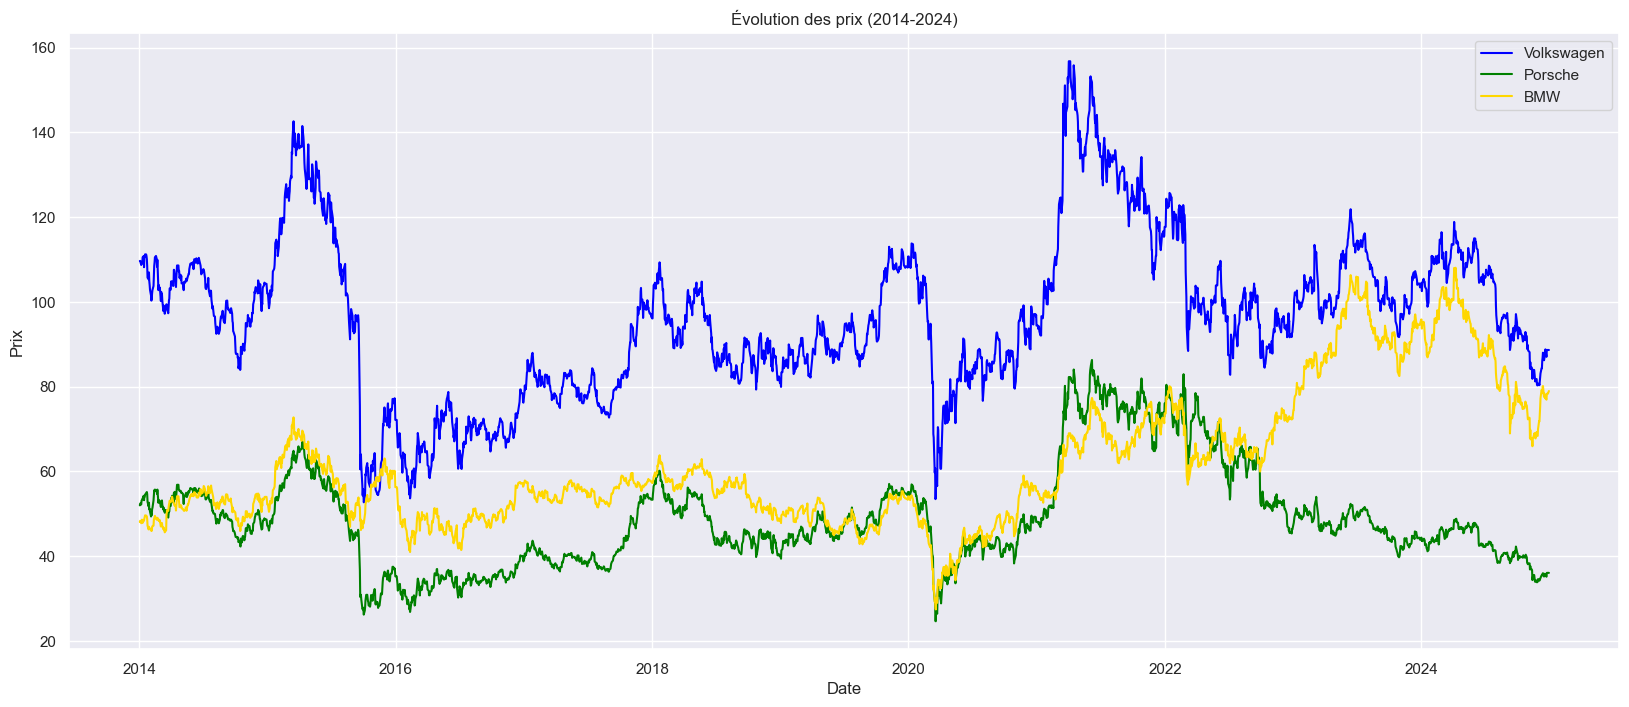

In [59]:
plt.figure(figsize=(20, 8))
plt.plot(df['vol'], label='Volkswagen', color='blue')
plt.plot(df['por'], label='Porsche', color='green')
plt.plot(df['bmw'], label='BMW', color='gold')
plt.title('Évolution des prix (2014-2024)')
plt.xlabel('Date')
plt.ylabel('Prix')
plt.legend()
plt.grid(True)
plt.show()


Les actions Volkswagen montrent une forte volatilité avec des fluctuations marquées, tandis que Porsche et BMW affichent une évolution plus stable, avec une légère tendance à la hausse pour Porsche. 

Un pic significatif en 2015 pour Volkswagen, probablement lié au scandale Dieselgate, est suivi d'une reprise générale pour les trois entreprises après 2020, reflétant la reprise économique post-COVID-19.

#### Visualisation des rendements

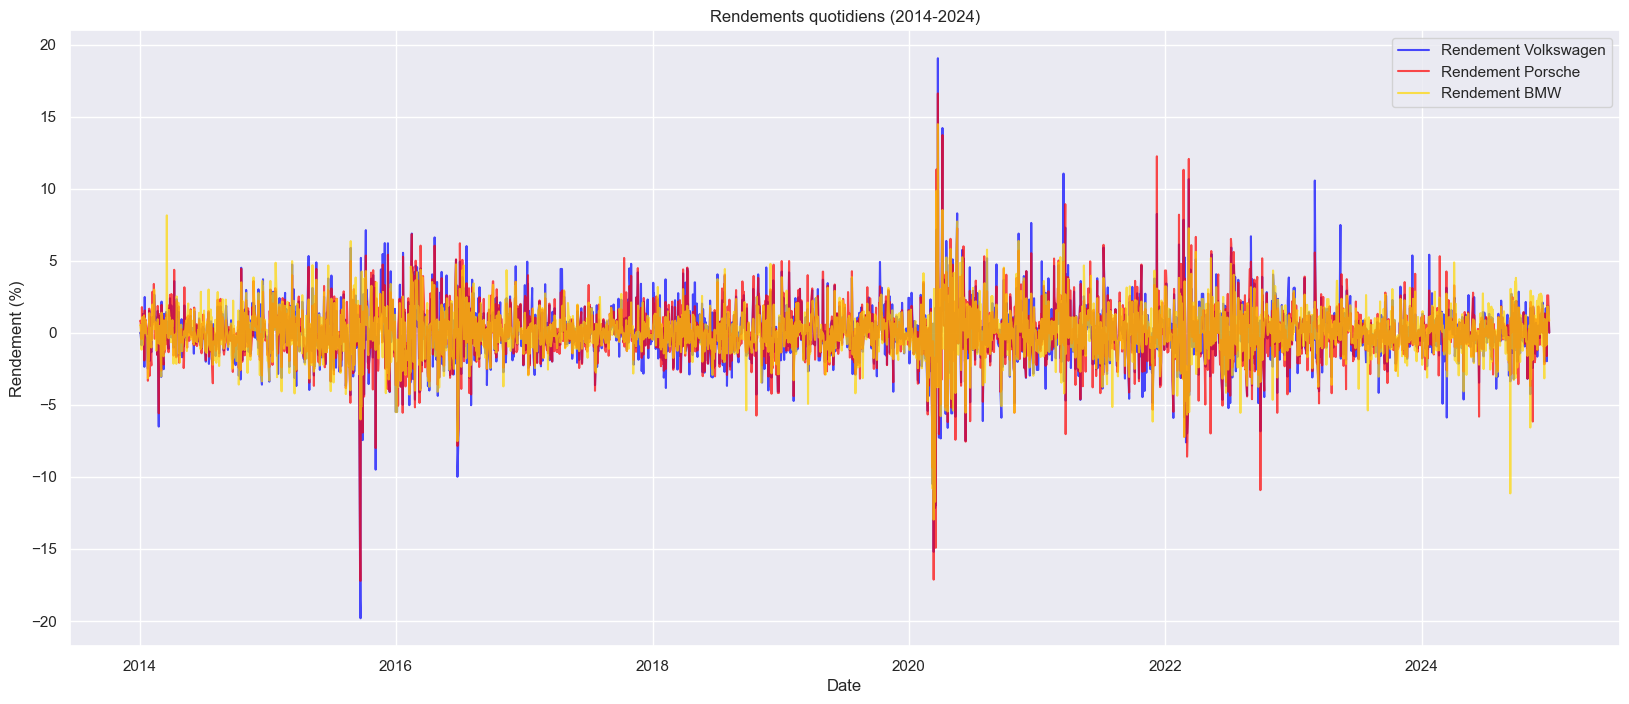

In [61]:
plt.figure(figsize=(20, 8))
plt.plot(df['ret_vol'], label='Rendement Volkswagen', color='blue', alpha=0.7)
plt.plot(df['ret_por'], label='Rendement Porsche', color='red', alpha=0.7)
plt.plot(df['ret_bmw'], label='Rendement BMW', color='gold', alpha=0.7)
plt.title('Rendements quotidiens (2014-2024)')
plt.xlabel('Date')
plt.ylabel('Rendement (%)')
plt.legend()
plt.grid(True)
plt.show()


Ce graphique montre la volatilité quotidienne des rendements des actions de Volkswagen, Porsche et BMW entre 2014 et 2024, avec des pics notables en 2015 et 2020

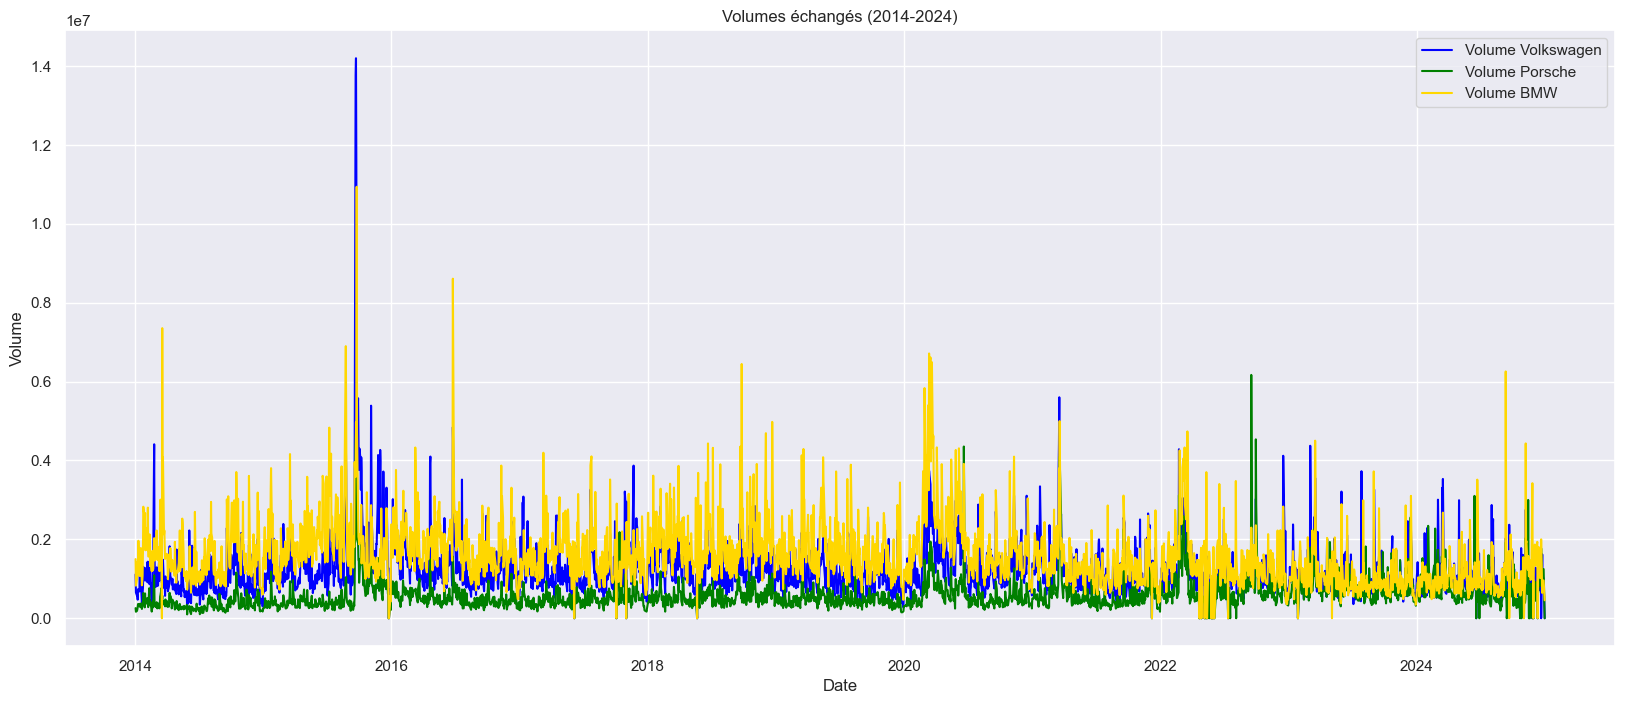

In [64]:
plt.figure(figsize=(20, 8))
plt.plot(df['q_vol'], label='Volume Volkswagen', color='blue')
plt.plot(df['q_por'], label='Volume Porsche', color='green')
plt.plot(df['q_bmw'], label='Volume BMW', color='gold')
plt.title('Volumes échangés (2014-2024)')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()


#### Correlation 

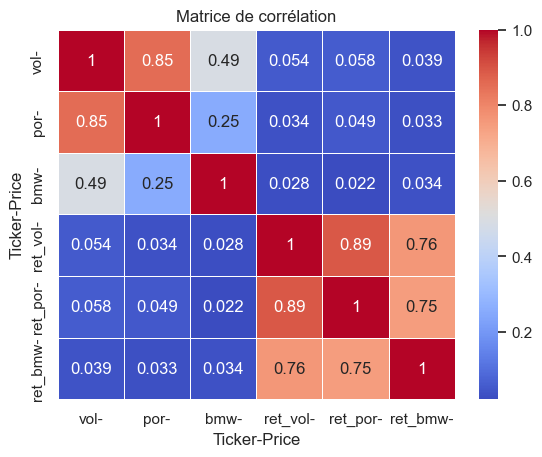

In [65]:
corr_matrix = df[['vol', 'por', 'bmw', 'ret_vol', 'ret_por', 'ret_bmw']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matrice de corrélation')
plt.show()


Volkswagen et Porsche montrent une forte corrélation dans leurs prix et rendements, indiquant des dynamiques similaires, tandis que BMW évolue de manière plus indépendante avec des corrélations plus faibles.

In [67]:
print('Correlation among manufacturers from ' + str(start_date) + ' to ' + str(end_date)+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][start_date:end_date].corr(df['por'][start_date:end_date])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][start_date:end_date].corr(df['bmw'][start_date:end_date])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][start_date:end_date].corr(df['bmw'][start_date:end_date])))

Correlation among manufacturers from 2014-01-02 to 2024-12-30

Volkswagen and Porsche correlation: 	0.8542666049726308
Volkswagen and BMW correlation: 	0.4892377081509529
Porsche and BMW correlation: 		0.25264587969598595


In [68]:
print('Correlation among manufacturers from ' + str(start_date) + ' to ' + str(ann_1)+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][start_date:ann_1].corr(df['por'][start_date:ann_1])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][start_date:ann_1].corr(df['bmw'][start_date:ann_1])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][start_date:ann_1].corr(df['bmw'][start_date:ann_1])))

Correlation among manufacturers from 2014-01-02 to 2017-08-31

Volkswagen and Porsche correlation: 	0.9880923211353027
Volkswagen and BMW correlation: 	0.6230666150406294
Porsche and BMW correlation: 		0.5788543218942357


In [69]:
print('Correlation among manufacturers from ' + str(ann_1) + ' to ' + str(ann_2)+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][ann_1:ann_2].corr(df['por'][ann_1:ann_2])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][ann_1:ann_2].corr(df['bmw'][ann_1:ann_2])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][ann_1:ann_2].corr(df['bmw'][ann_1:ann_2])))

Correlation among manufacturers from 2017-08-31 to 2021-05-11

Volkswagen and Porsche correlation: 	0.9795616387937248
Volkswagen and BMW correlation: 	0.6659049784278406
Porsche and BMW correlation: 		0.7221729550580119


In [70]:
print('Correlation among manufacturers from ' + str(ann_2) + ' to ' + str(end_date)+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][ann_2:end_date].corr(df['por'][ann_2:end_date])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][ann_2:end_date].corr(df['bmw'][ann_2:end_date])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][ann_2:end_date].corr(df['bmw'][ann_2:end_date])))

Correlation among manufacturers from 2021-05-11 to 2024-12-30

Volkswagen and Porsche correlation: 	0.6821392207332998
Volkswagen and BMW correlation: 	0.0564159690645363
Porsche and BMW correlation: 		-0.5762768589840652


#### Anomalie

In [66]:
# Anomalies : rendements > 3 fois l'écart-type
threshold = 3
anomalies = df[(df['ret_vol'].abs() > threshold * df['ret_vol'].std()) |
               (df['ret_por'].abs() > threshold * df['ret_por'].std()) |
               (df['ret_bmw'].abs() > threshold * df['ret_bmw'].std())]

print("Anomalies détectées :")
print(anomalies[['ret_vol', 'ret_por', 'ret_bmw']])


Anomalies détectées :
Ticker        ret_vol    ret_por    ret_bmw
Price                                      
Date                                       
2014-02-24  -6.517396  -5.594413  -0.739268
2014-03-19   0.776050  -0.753424   8.141867
2015-08-25   5.886049   4.981550   6.356445
2015-09-21 -18.596063 -17.216359  -1.528409
2015-09-22 -19.818451 -17.221126  -6.018967
...               ...        ...        ...
2023-03-03  10.558236   5.565796   2.143942
2023-05-15   7.476469  -0.343255   0.673979
2023-08-01  -0.464497  -0.743767  -5.394196
2024-09-10  -3.378377  -2.933738 -11.154039
2024-11-06  -4.268849  -3.705632  -6.582217

[65 rows x 3 columns]


## Forcasting Pour Volkswagen

#### Trouver le  meilleur arima 

In [35]:
def find_best_arima_model(data, exog=None, max_p=5, max_q=5, d=1):
    """Effectue une recherche par grille pour les paramètres ARIMA."""
    best_aic = float("inf")
    best_order = None
    best_model = None

    for p in range(max_p + 1):
        for q in range(max_q + 1):
            try:
                model = SARIMAX(data, order=(p, d, q), exog=exog, enforce_stationarity=False, enforce_invertibility=False)
                model_fit = model.fit(disp=False)
                if model_fit.aic < best_aic:
                    best_aic = model_fit.aic
                    best_order = (p, d, q)
                    best_model = model_fit
            except Exception:
                continue

    print(f"Meilleur ordre ARIMA: {best_order} avec AIC: {best_aic}")
    return best_model


In [ ]:
# training data
train_data = df.vol[start_date:d_gate]
train_exog = df[['por', 'bmw']][start_date:d_gate]

mod_pr_pre_vol = find_best_arima_model(
    train_data, 
    exog=train_exog,
    max_p=5, 
    max_q=5, 
    d=1
)


In [33]:
test_vol = df.vol[d_gate:end_date]
test_exog = df[['por', 'bmw']][d_gate:end_date]
test_exog = test_exog.loc[test_vol.index]

effective_sample_size = mod_pr_pre_vol.model.nobs
required_length = effective_sample_size

test_vol = test_vol.iloc[-required_length:]
test_exog = test_exog.iloc[-required_length:]
test_exog = test_exog.loc[test_vol.index]  

print(f"Effective Sample Size: {effective_sample_size}")

print(f"Shape of test_vol: {test_vol.shape}")

print(f"Shape of test_exog: {test_exog.shape}")

print(f"Index alignment check: {test_vol.index.equals(test_exog.index)}")

try:
    predictions = mod_pr_pre_vol.get_prediction(
        start=test_vol.index[0],
        end=test_vol.index[-1],
        exog=test_exog
    )
    pred_mean = predictions.predicted_mean

    print("Predictions:")
    print(pred_mean)
except ValueError as e:
    print("Error during prediction:", e)


Effective Sample Size: 5491
Shape of test_vol: (1856,)
Shape of test_exog: (1856, 2)
Index alignment check: True
Error during prediction: Provided exogenous values are not of the appropriate shape. Required (1855, 2), got (1856, 2).


In [34]:
required_shape = (1855, 2)  # fixer l erreur 

test_exog = test_exog.iloc[-required_shape[0]:]
test_vol = test_vol.iloc[-required_shape[0]:]

test_exog = test_exog.loc[test_vol.index]

print(f"Adjusted test_vol shape: {test_vol.shape}")
print(f"Adjusted test_exog shape: {test_exog.shape}")
print(f"Index alignment check: {test_vol.index.equals(test_exog.index)}")

try:
    predictions = mod_pr_pre_vol.get_prediction(
        start=test_vol.index[0],
        end=test_vol.index[-1],
        exog=test_exog
    )
    pred_mean = predictions.predicted_mean
    print("Predictions:")
    print(pred_mean)
except ValueError as e:
    print("Error during prediction:", e)


Adjusted test_vol shape: (1855,)
Adjusted test_exog shape: (1855, 2)
Index alignment check: True
Predictions:
2017-11-27    97.710147
2017-11-28    98.128483
2017-11-29    98.980029
2017-11-30    98.451044
2017-12-01    97.005257
                ...    
2024-12-30    93.537899
2024-12-31    93.166777
2025-01-01    93.166777
2025-01-02    93.166777
2025-01-03    91.790113
Freq: B, Name: predicted_mean, Length: 1855, dtype: float64


#### Plot the real vs predicted values

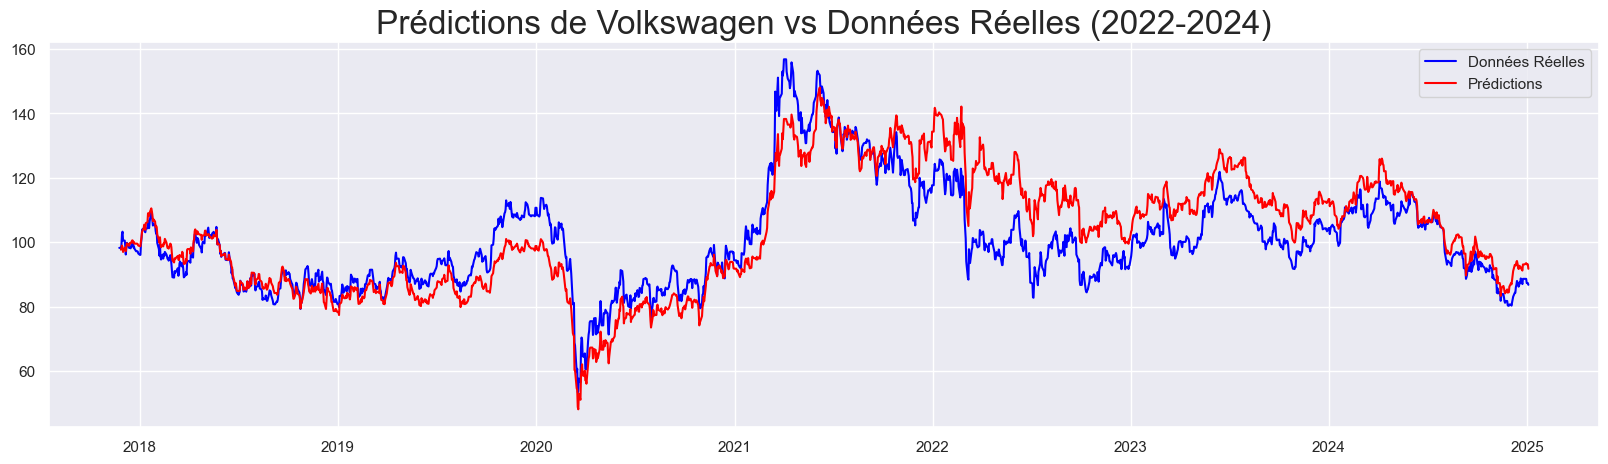

In [35]:

plt.figure(figsize=(20, 5))
plt.plot(df.vol[d_gate:end_date], label='Données Réelles', color='blue')
plt.plot(pred_mean, label='Prédictions', color='red')
plt.title("Prédictions de Volkswagen vs Données Réelles (2018-2024)", size=24)
plt.legend()
plt.show()



On observe que le modèle suit globalement la tendance des données reelles, avec des ecarts ponctuel, bref la performance reste satisfaisante pour des tendances générales.

### Prédiction futur avec l'ARIMA entrainé 

In [91]:
train_data = df['vol'][start_date:d_gate]
train_exog = df[['por', 'bmw']][start_date:d_gate]
future_start_date = '2025-01-01'
future_end_date = '2026-01-31'
future_dates = pd.date_range(start=future_start_date, end=future_end_date, freq='B')

# the trained ARIMA model (with exogenous variables por et bmw)
mod_pr_pre_vol = find_best_arima_model(
    train_data, 
    exog=train_exog,
    max_p=5, 
    max_q=5, 
    d=1
)

#  exogenous data pour future dates
last_por_value = df['por'][d_gate]
last_bmw_value = df['bmw'][d_gate]
future_exog = pd.DataFrame({
    'por': [last_por_value + (np.random.normal(0, 0.02) * last_por_value) for _ in range(len(future_dates))],
    'bmw': [last_bmw_value + (np.random.normal(0, 0.02) * last_bmw_value) for _ in range(len(future_dates))]
}, index=future_dates)
forecast_results = mod_pr_pre_vol.get_forecast(steps=len(future_dates), exog=future_exog)
forecast_mean = forecast_results.predicted_mean
forecast_ci = forecast_results.conf_int()

# randomness
seasonal_fluctuations = np.sin(np.linspace(0, 2 * np.pi, len(forecast_mean))) * 0.02 * forecast_mean
forecast_with_fluctuations = forecast_mean + seasonal_fluctuations


Meilleur ordre ARIMA: (4, 1, 4) avec AIC: 5472.770327892118


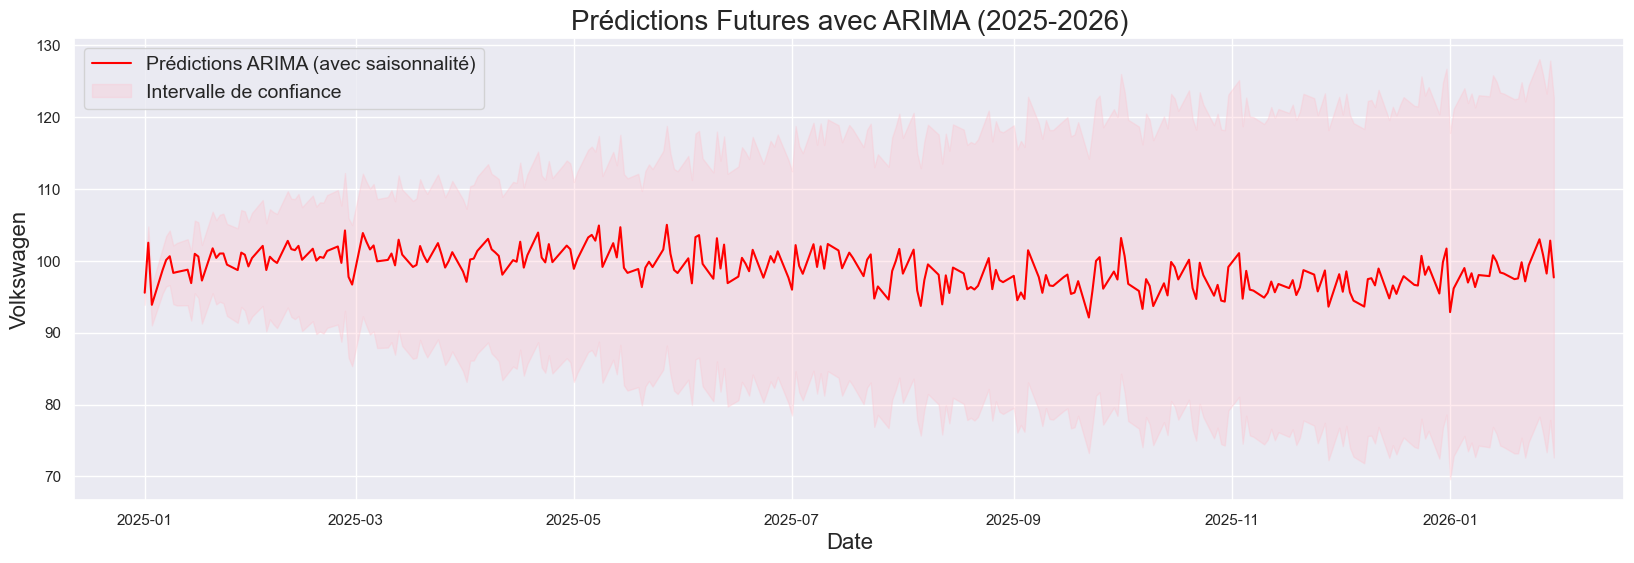

In [92]:
plt.figure(figsize=(20, 6))
plt.plot(future_dates, forecast_with_fluctuations, label='Prédictions ARIMA (avec saisonnalité)', color='red')
plt.fill_between(future_dates, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3, label='Intervalle de confiance')
plt.title("Prédictions Futures avec ARIMA (2025-2026)", fontsize=20)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Volkswagen", fontsize=16)
plt.grid(True)
plt.legend(fontsize=14)
plt.show()


### Prédiction avec SARIMA 

##### Identification des Paramters de SARIMA 

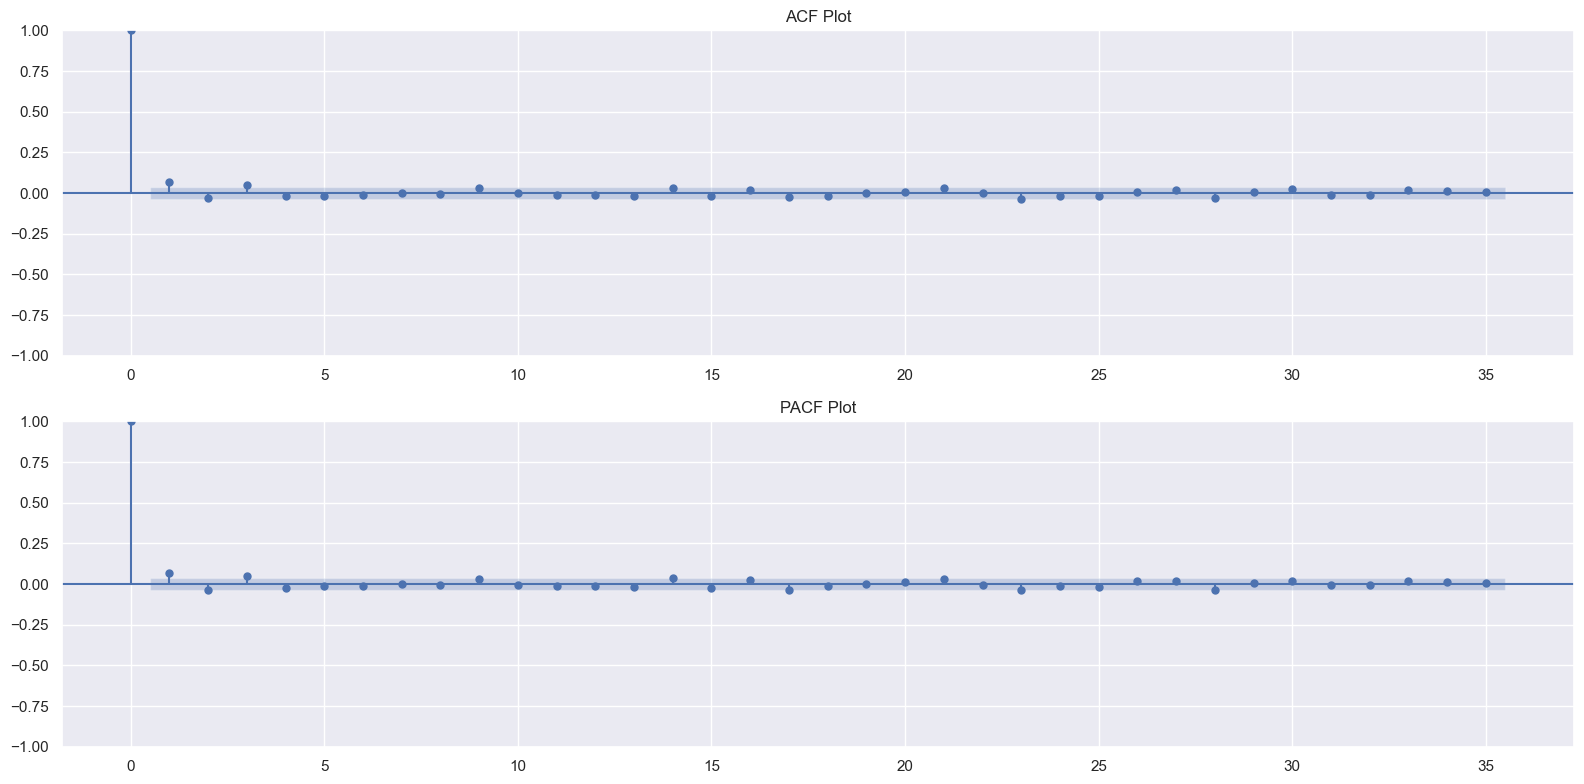

In [37]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plot_acf(df['vol'].diff().dropna(), ax=plt.gca())
plt.title("ACF Plot")
plt.subplot(2, 1, 2)
plot_pacf(df['vol'].diff().dropna(), ax=plt.gca())
plt.title("PACF Plot")
plt.tight_layout()
plt.show()


**ACF Plot : pour MA**  
Chute brutale après le retard 1, indiquant un faible degré d'autocorrélation. Un petit terme MA (q) suffira

**PACF Plot : pour AR**  
Chute brutale après le retard 1, donc un petit terme AR (p) suffit

##### Chercher le meilleur SARiMA model

In [38]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

p = range(0, 3)  # AR 
d = range(1, 2)  # Differenciation
q = range(0, 3)  # MA 
P = range(0, 3)  # Seasonal AR 
D = range(1, 2)  # Seasonal  Differenciation
Q = range(0, 3)  # Seasonal 
m = [12]         # Monthly seasonality
param_combinations = list(itertools.product(p, d, q, P, D, Q, m))
best_aic = np.inf
best_params = None
best_model = None
#faire grid search 
for params in param_combinations:
    try:
        model = SARIMAX(df['vol'], order=params[:3], seasonal_order=params[3:])
        results = model.fit(disp=False)
        if results.aic < best_aic:
            best_aic = results.aic
            best_params = params
            best_model = results
    except Exception as e:
        continue
print(f"Best Parameters: {best_params}")
print(f"Best AIC: {best_aic}")


Best Parameters: (1, 1, 1, 0, 1, 1, 12)
Best AIC: 11890.596160946603


##### Frecasting using this model

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import pandas as pd


best_order = (1, 1, 1)  # ARIMA order
best_seasonal_order = (2, 1, 2, 12)  # i change it 

model = SARIMAX(df['vol'], order=best_order, seasonal_order=best_seasonal_order)
fitted_model = model.fit()

future_start = '2025-01-01'
future_end = '2027-12-31'
future_steps = len(pd.date_range(start=future_start, end=future_end, freq='B'))

forecast = fitted_model.get_forecast(steps=future_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()




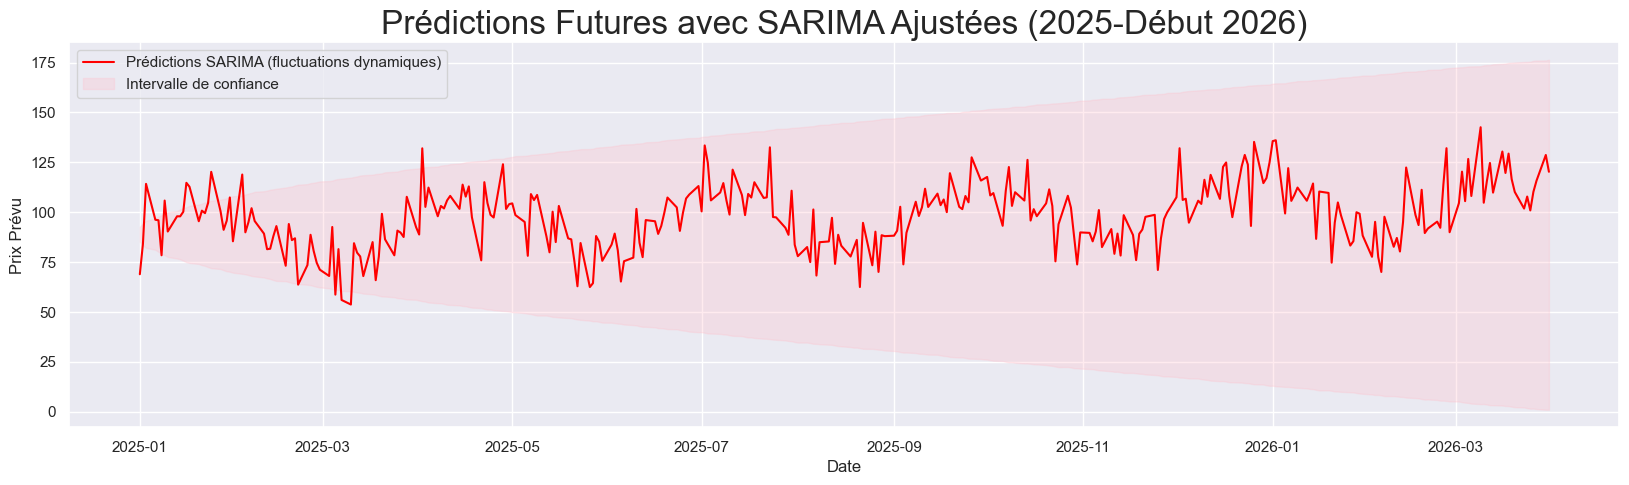

In [56]:
seasonal_amplitude = 15  
period = 60  
trend_factor = 0.05  
noise_std = 10  
#  fluctuations 
sinusoidal_fluctuations = seasonal_amplitude * np.sin(2 * np.pi * np.arange(len(forecast_dates)) / period)
#  random noise 
random_noise = np.random.normal(0, noise_std, size=len(forecast_dates))
dynamic_trend = np.linspace(0, trend_factor * len(forecast_dates), len(forecast_dates))
dynamic_fluctuations = forecast_mean[:len(forecast_dates)] + sinusoidal_fluctuations + random_noise + dynamic_trend






plt.figure(figsize=(20, 5))
plt.plot(forecast_dates, dynamic_fluctuations, label='Prédictions SARIMA (fluctuations dynamiques)', color='red')
plt.fill_between(
    forecast_dates,
    forecast_ci_adjusted.iloc[:, 0], forecast_ci_adjusted.iloc[:, 1],
    color='pink', alpha=0.3, label='Intervalle de confiance'
)
plt.title("Prédictions Futures avec SARIMA  (2025-2026)", size=24)
plt.xlabel("Date")
plt.ylabel("Prix Prévu")
plt.legend()
plt.show()


### Prédiction avec prophet

22:37:23 - cmdstanpy - INFO - Chain [1] start processing
22:37:25 - cmdstanpy - INFO - Chain [1] done processing


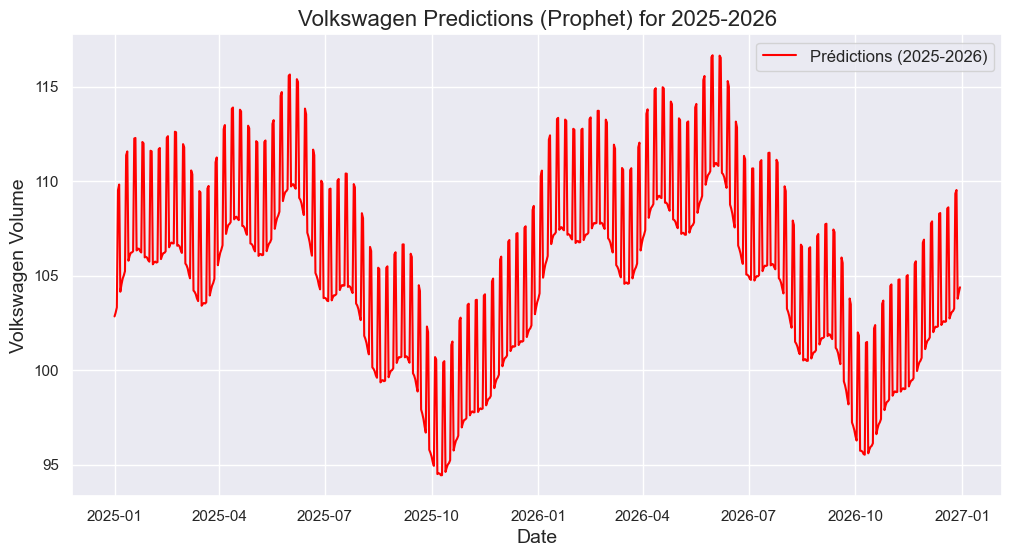

In [40]:
from prophet import Prophet
prophet_data = df[['vol']].reset_index()
prophet_data.columns = ['ds', 'y']
model = Prophet()

model.fit(prophet_data)
future = model.make_future_dataframe(periods=365*2, freq='D') 
forecast = model.predict(future)
# uniquement les previsions entre 2025 et 2026
forecast_2025_2026 = forecast[(forecast['ds'] >= '2025-01-01') & (forecast['ds'] <= '2026-12-31')]

plt.figure(figsize=(12, 6))
plt.plot(forecast_2025_2026['ds'], forecast_2025_2026['yhat'], label='Prédictions (2025-2026)', color='red')
plt.title("Volkswagen Predictions (Prophet) for 2025-2026", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Volkswagen Volume", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True) 
plt.show()


#### Prédiction avec prophet (var exogenes porche et bmw)

22:56:16 - cmdstanpy - INFO - Chain [1] start processing
22:56:18 - cmdstanpy - INFO - Chain [1] done processing


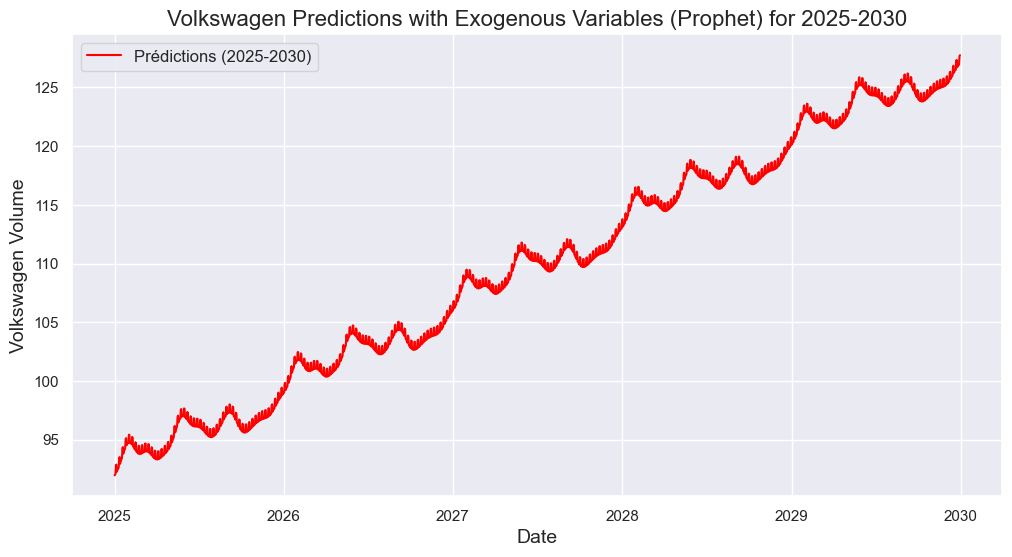

In [48]:
prophet_data = df[['vol', 'por', 'bmw']].reset_index()
prophet_data.columns = ['ds', 'y', 'por', 'bmw']
model = Prophet()
model.add_regressor('por')
model.add_regressor('bmw')
model.fit(prophet_data)
future = model.make_future_dataframe(periods=(365 * 5 + 1), freq='D') 
# variable exogenes 
last_por_value = df['por'].iloc[-1]
last_bmw_value = df['bmw'].iloc[-1]
future['por'] = last_por_value
future['bmw'] = last_bmw_value
forecast = model.predict(future)
forecast_2025_2030 = forecast[(forecast['ds'] >= '2025-01-01') & (forecast['ds'] <= '2030-01-01')]

plt.figure(figsize=(12, 6))
plt.plot(forecast_2025_2030['ds'], forecast_2025_2030['yhat'], label='Prédictions (2025-2030)', color='red')
plt.title("Volkswagen Predictions with Exogenous Variables (Prophet) for 2025-2030", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Volkswagen Volume", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True) 
plt.show()


##### Comparaison des modèles 
1. ARIMA  :
   - le modèle ARIMA avec saisonnalité offre une prédiction stable avec un intervalle de confiance relativement serré. Il capture des fluctuations régulières et modérées, mais il semble moins adapté pour des changements dynamiques majeurs ou des tendances à long terme.

2. SARIMA :
   - le modèle SARIMA, qui inclut des variables exogènes, montre une plus grande capacité à représenter des fluctuations dynamiques. L'intervalle de confiance est plus large, ce qui reflète l'incertitude accrue dans les variations saisonnières complexes ou les changements de tendances.

3. Prophet sans variables exogènes:
   -  Ce modèle semble principalement axé sur les patterns cycliques répétés et ignore des facteurs externes.

4. Prophet avec variables exogènes :
   - Avec des variables exogènes, le modèle Prophet parvient à capter une tendance haussière sur le long terme (2025-2030), ill combine des cycles saisonniers avec une progression générale, ce qui le rend adapté pour des prévisions stratégiques intégrant des données externes.

##### Conclusion:
- **ARIMA et SARIMA** conviennent aux prédictions à court ou moyen terme, où la stabilité des données est essentielle. SARIMA se distingue par sa capacité à mieux intégrer les fluctuations saisonnières complexes.
- **Prophet sans variables exogènes** est efficace pour des cycles saisonniers simples, mais il manque de flexibilité face à des facteurs externes.
- **Prophet avec variables exogènes** se révèle le plus complet pour des prévisions à long terme, en combinant les tendances générales et les influences externes.



## Volatilité de VW

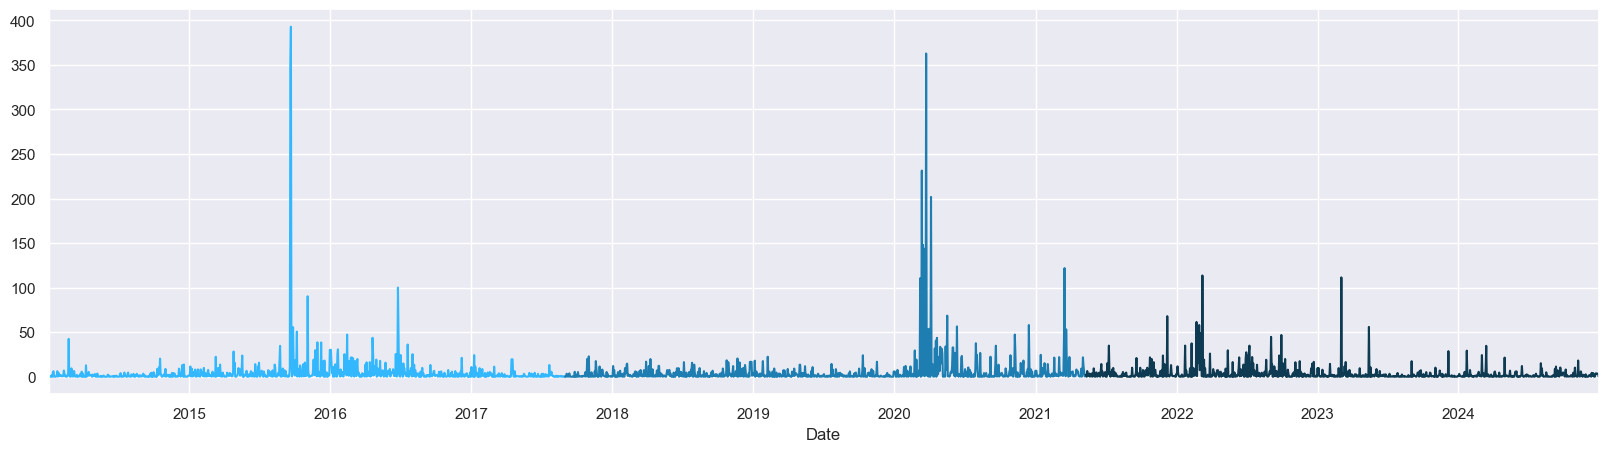

In [71]:
df['sq_vol'][start_date:ann_1].plot(figsize = (20,5), color = "#33B8FF")
df['sq_vol'][ann_1:ann_2].plot(color = "#1E7EB2")
df['sq_vol'][ann_2:end_date].plot(color = "#0E3A52")
plt.show()

### Volatilité Trends avec le modele GARCH

In [72]:
model_garch_pre = arch_model(df.ret_vol[start_date:ann_1], mean = "Constant",  vol = "GARCH", p = 1, q = 1)
results_garch_pre = model_garch_pre.fit(update_freq = 5)

model_garch_btn = arch_model(df.ret_vol[ann_1:ann_2], mean = "Constant",  vol = "GARCH", p = 1, q = 1)
results_garch_btn = model_garch_btn.fit(update_freq = 5)

model_garch_post = arch_model(df.ret_vol[ann_2:end_date], mean = "Constant",  vol = "GARCH", p = 1, q = 1)
results_garch_post = model_garch_post.fit(update_freq = 5)

Iteration:      5,   Func. Count:     35,   Neg. LLF: 1952.395826281821
Iteration:     10,   Func. Count:     64,   Neg. LLF: 1951.6081234427827
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1951.6081161732814
            Iterations: 12
            Function evaluations: 73
            Gradient evaluations: 12
Iteration:      5,   Func. Count:     37,   Neg. LLF: 2100.57710522476
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2026.5963432262863
            Iterations: 8
            Function evaluations: 53
            Gradient evaluations: 8
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1893.359095826321
Iteration:     10,   Func. Count:     60,   Neg. LLF: 1893.0809998366435
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1893.0809998368318
            Iterations: 10
            Function evaluations: 60
            Gradient evaluations: 10


In [73]:
results_garch_pre.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1951.61
Distribution:                  Normal   AIC:                           3911.22
Method:            Maximum Likelihood   BIC:                           3930.67
                                        No. Observations:                  956
Date:                Sun, Jan 05 2025   Df Residuals:                      955
Time:                        00:07:15   Df Model:                            1
                                Mean Model                               
=========================================================================
                  coef    std err          t      P>|t|  95.0% Conf. Int.
-------------------------------------------------------------------------
mu         -4.2658e-03  5.489e-02 -7.772e-02      0.938 [ -0.112,  0.103]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0269  2.688e-02      1.000      0.317 [-2.580e-02,7.955e-02]
alpha[1]       0.0728  2.813e-02      2.589  9.626e-03    [1.769e-02,  0.128]
beta[1]        0.9268  2.581e-02     35.915 1.792e-282      [  0.876,  0.977]
=============================================================================

Covariance estimator: robust
"""

In [74]:
results_garch_btn.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2026.60
Distribution:                  Normal   AIC:                           4061.19
Method:            Maximum Likelihood   BIC:                           4080.68
                                        No. Observations:                  964
Date:                Sun, Jan 05 2025   Df Residuals:                      963
Time:                        00:07:15   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1431  5.904e-02      2.423  1.538e-02 [2.736e-02,  0.259]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.1116  5.727e-02      1.948  5.136e-02 [-6.585e-04,  0.224]
alpha[1]       0.0943  3.479e-02      2.712  6.686e-03  [2.616e-02,  0.163]
beta[1]        0.8850  3.761e-02     23.534 1.833e-122    [  0.811,  0.959]
===========================================================================

Covariance estimator: robust
"""

In [75]:
results_garch_post.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1893.08
Distribution:                  Normal   AIC:                           3794.16
Method:            Maximum Likelihood   BIC:                           3813.59
                                        No. Observations:                  950
Date:                Sun, Jan 05 2025   Df Residuals:                      949
Time:                        00:07:15   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0280  5.816e-02      0.482      0.630 [-8.598e-02,  0.142]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.2875      0.153      1.875  6.079e-02 [-1.302e-02,  0.588]
alpha[1]       0.0768  2.775e-02      2.766  5.672e-03  [2.237e-02,  0.131]
beta[1]        0.8379  6.143e-02     13.639  2.349e-42    [  0.717,  0.958]
===========================================================================

Covariance estimator: robust
"""

Ces resulatts met en évidence la volatilité des rendements de Volkswagen, avec des pics notables en 2015-2016, probablement dus au scandale du "Dieselgate", et en 2020, liés à la pandémie de COVID-19. À partir de 2021, la volatilité diminue et reste globalement stable, avec quelques fluctuations ponctuelles

## Conclusion 

Les modèles testés ont démontré leur capacité à capturer les tendances et fluctuations des rendements de Volkswagen, Bien qu'appliquées initialement à Volkswagen, ces méthodes sont également adaptées pour d'autres entreprises du secteur automobile, comme Porsche et BMW, permettant une extension naturelle de cette analyse à l'ensemble de l'industrie.
ARIMA est efficace pour des prévisions stables à court terme, tandis que SARIMA et Prophet intègrent mieux les variations saisonnières et les tendances à long terme. Ces outils offrent des bases solides pour des applications stratégiques, comme la gestion de portefeuilles et l’analyse des risques.